In [2]:
import tensorflow as tf
from keras.layers import Input, Lambda,subtract,GlobalMaxPooling2D,Dense,GlobalAveragePooling2D, concatenate, Activation
from keras.applications.mobilenet import MobileNet as Net

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.layers import Input, merge
from keras.optimizers import Adam
import cv2
import numpy as np
import os
from tqdm import tqdm
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

ALPHA = 0.3  # Triplet Loss Parameter

In [3]:
# Source: https://github.com/davidsandberg/facenet/blob/master/src/facenet.py
def triplet_loss(x):
    anchor, positive, negative = x

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss


In [4]:
def make_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    return model
    
    

In [5]:
def create_model(d1, d2, c):
    
    # The triplet network takes 3 input images: 2 of the same class and 1 out-of-class sample
    anchor_example = Input(shape=(d1, d2, c), name = 'anchor')
    positive_example = Input(shape=(d1, d2, c), name = 'positive')
    negative_example = Input(shape=(d1, d2, c), name = 'negative')
        
    base_model = make_model((d1, d2, c))
    # the weights of this layer will be set to ones and fixed  (since they
    # are shared we could also leave them trainable to get a weighted sum)
    
    # feed all 3 inputs into the pretrained keras model
    x1 = base_model(anchor_example)
    x2 = base_model(positive_example)
    x3 = base_model(negative_example)
    
    # flatten/summarize the models output:
    # (here we could also use GlobalAveragePooling or simply Flatten everything)
    anchor = GlobalMaxPooling2D()(x1)
    positive = GlobalMaxPooling2D()(x2)
    negative = GlobalMaxPooling2D()(x3)

    loss = merge([anchor, positive, negative], mode=triplet_loss, output_shape=(1,))

    
    model = Model(inputs=[anchor_example, positive_example, negative_example],
                  outputs=loss)
    
    model.compile(loss='mean_absolute_error', optimizer=Adam())
    print(model.summary())
    
    return model

In [6]:
model = create_model(28, 28, 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 12, 12, 64)   19392       anchor[0][0]                     
                                                                 positive[0][0]                   
          

/Users/s0c02nj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/s0c02nj/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


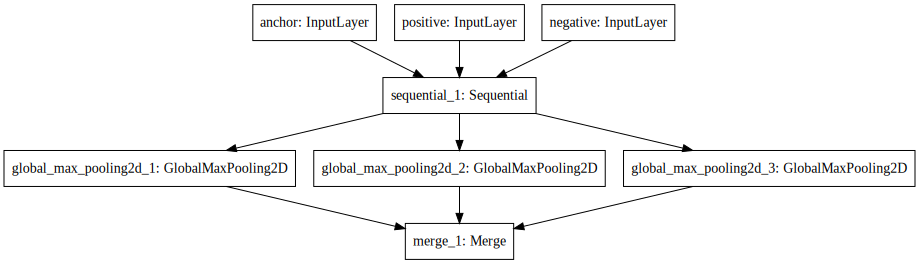

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
!rm 'images/.DS_Store'

rm: cannot remove 'images/.DS_Store': No such file or directory


In [7]:
def load_images(path):
    
    dataset=[]
    labels = os.listdir(path)
    
    for label in tqdm(labels):
        
        images = os.listdir(path+"/"+label)
        
        for image in list(filter(lambda a: '.DS_Store' != a, images)):
            anchor = cv2.imread(path+"/"+label+"/"+image)
            for image1 in list(filter(lambda a: '.DS_Store' != a, images)):
                p_img = cv2.imread(path+"/"+label+"/"+image1)
                labels1 = [i for i in labels if i!=label]
                
                for label1 in labels1:
                    images2 = os.listdir(path+"/"+label1)
                    for image2 in list(filter(lambda a: '.DS_Store' != a, images2)):
                        n_img = cv2.imread(path+"/"+label1+"/"+image2)
                        dataset.append((anchor, p_img, n_img))
    return dataset

In [8]:
def generator():
    dataset=load_images("images")

    anchor=[]
    p_img=[]
    n_img=[]
    
    for i,j,k in dataset:
        anchor.append(i)
        p_img.append(j)
        n_img.append(k)
    
    anchor=np.array(anchor)
    p_img=np.array(p_img)
    n_img=np.array(n_img)
    
    return anchor, p_img, n_img

In [9]:
anchor, p_img, n_img = generator()

100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


In [10]:
print(anchor.shape)

(958320, 28, 28, 3)


In [23]:
model.fit(x=[anchor, p_img, n_img], y=np.zeros(anchor.shape[0]), verbose=1, batch_size=2048, epochs=2) 

Epoch 1/2
958320/958320 [==============================] - 91s 95us/step - loss: 13.6922
Epoch 2/2
958320/958320 [==============================] - 89s 92us/step - loss: 0.0342


In [25]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('global_max_pooling2d_4').output)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

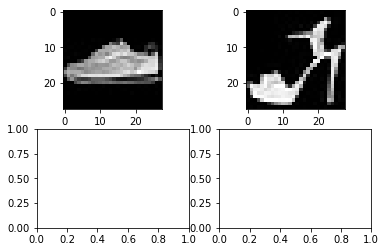

distance between above two images 13.3581


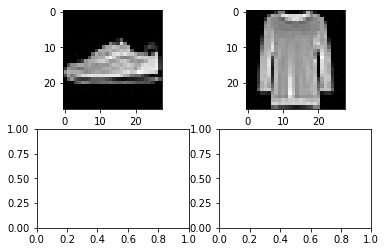

distance between above two images 12.5803


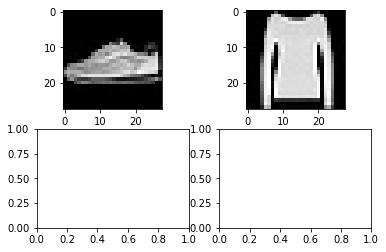

distance between above two images 11.7863


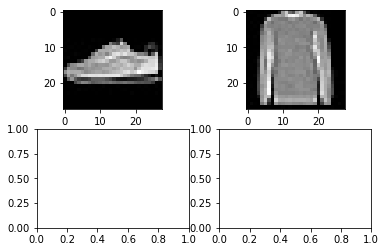

distance between above two images 10.6913


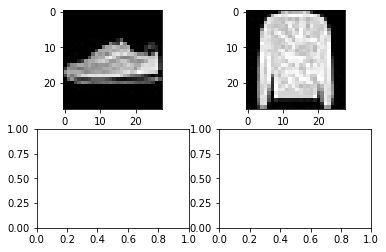

distance between above two images 10.7917


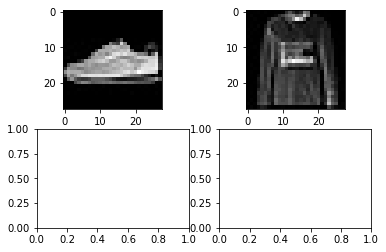

distance between above two images 10.9963


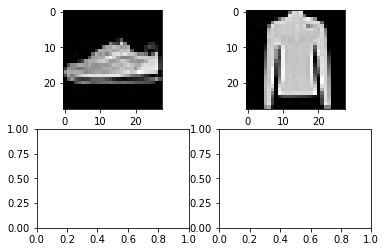

distance between above two images 11.9062


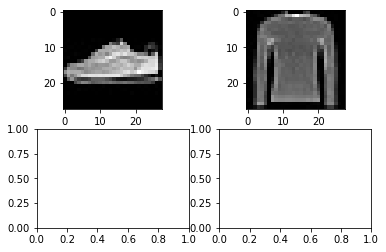

distance between above two images 10.2942


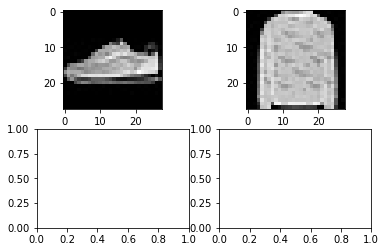

distance between above two images 10.0635


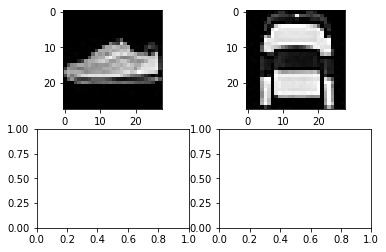

distance between above two images 11.9393


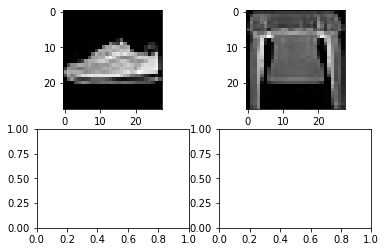

distance between above two images 11.123


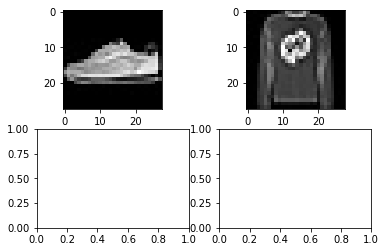

distance between above two images 10.4309


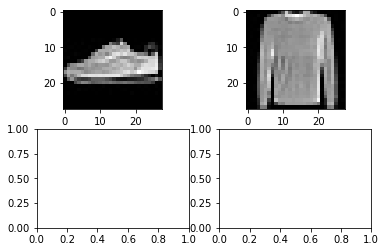

distance between above two images 11.1519


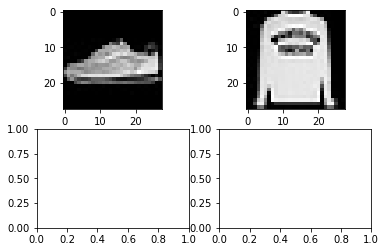

distance between above two images 10.5206


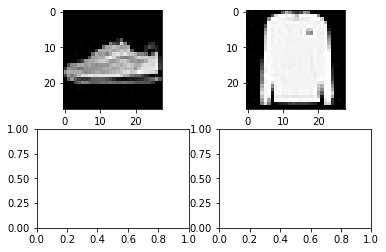

distance between above two images 11.6431


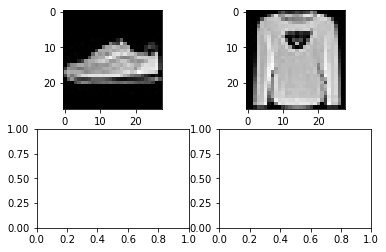

distance between above two images 11.174


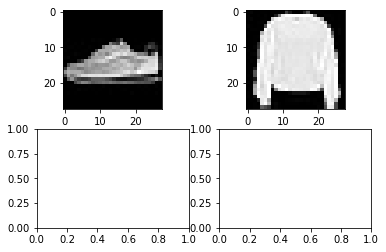

distance between above two images 10.7183


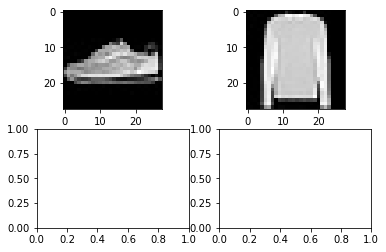

distance between above two images 10.5748


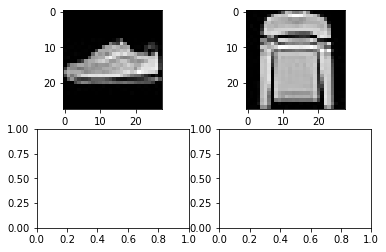

distance between above two images 11.6053


In [30]:
for i in range(21, 40):
    
    f, axarr = plt.subplots(2,2)
    
    intermediate_output_a = intermediate_layer_model.predict([anchor[i-1:i], p_img[i-1:i], n_img[i-1:i]])
    intermediate_output_b = intermediate_layer_model.predict([n_img[i-1:i], p_img[i-1:i], p_img[i-1:i]])
    
    axarr[0,0].imshow(anchor[i])
    axarr[0,1].imshow(n_img[i])
    
    plt.show()
    print "distance between above two images", np.linalg.norm(intermediate_output_a[0]-intermediate_output_b[0])
    
    

